## Project 8 - Credit Risk - Part 1

### Notebook Content

1. Exploratory Data Analysis
2. Data Preparation

## 1. Exploratory Data Analysis 
---



Import libraries:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

import scipy.stats as stats
from feature_engine import imputation as mdi        
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
from feature_engine.outliers import OutlierTrimmer

Import dataset:

In [6]:
data = pd.read_csv('dataset/german_credit_data_risk.csv') 

In [9]:
data.head(2)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad


We'll start deleting unusefull columns and changing our target column categories names

In [7]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [8]:
data['Risk'] = data['Risk'].map({'good': 0, 'bad': 1})

Our dataset now looks like this:

In [9]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


In [31]:
data.describe()

,Unnamed: 0,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,35.546000,1.904000,3271.258000,20.903000
std,288.819436,11.375469,0.653614,2822.736876,12.058814
min,0.000000,19.000000,0.000000,250.000000,4.000000
25%,249.750000,27.000000,2.000000,1365.500000,12.000000
50%,499.500000,33.000000,2.000000,2319.500000,18.000000
75%,749.250000,42.000000,2.000000,3972.250000,24.000000
max,999.000000,75.000000,3.000000,18424.000000,72.000000


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


2 Features, 'Saving accounts' and 'Checking account' have missing values.

### Distribution analysis

In [43]:
def diagnostic_plots(df, variable):      
    plt.figure(figsize=(11, 3))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

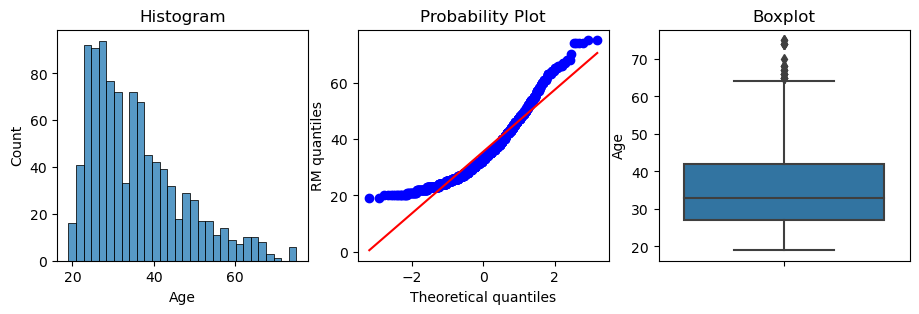

In [44]:
diagnostic_plots(data, 'Age')

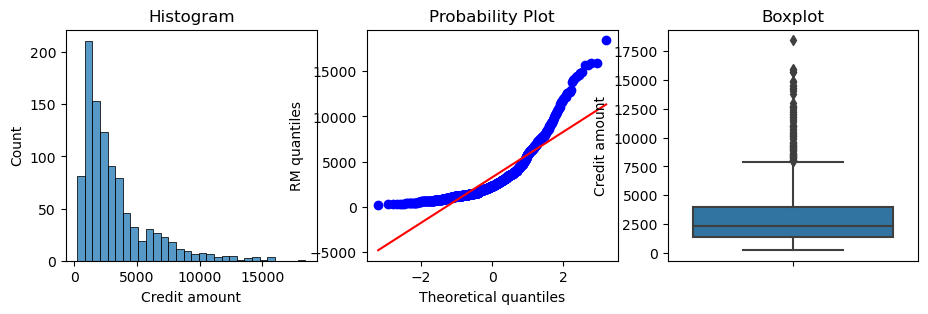

In [45]:
diagnostic_plots(data, 'Credit amount')

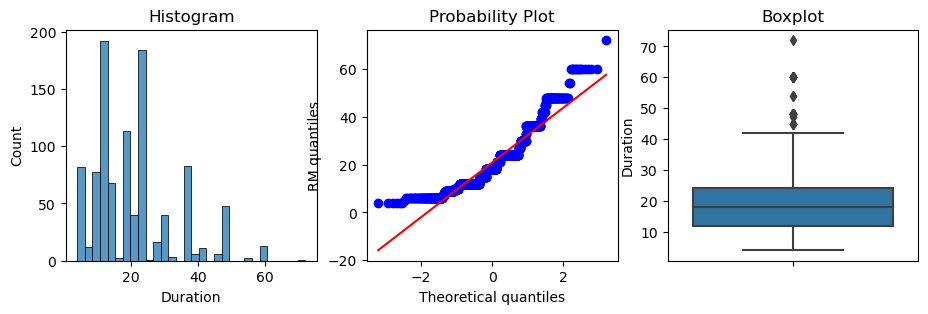

In [46]:
diagnostic_plots(data, 'Duration')

Numerical variables have skewed distributions.

### Missing values instances

As we've already seen, 2 Categorical variables have missing values.

In [22]:
data.isnull().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

### Find numerical variables (continuous, discrete, target)

In [62]:
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables:'.format(len(numerical)))
numerical

There are 5 numerical variables:


['Age', 'Job', 'Credit amount', 'Duration', 'Risk']

### Find discrete variables

We will select the ones that contain a finite and small number of distinct values from all the numerical ones:

In [63]:
discrete = []

for var in numerical:
    if len(data[var].unique()) < 20:
        print(var, 'values: ', data[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))

Job values:  [2 1 3 0]
Risk values:  [0 1]

There are 2 discrete variables


### Continuous variables

In [67]:
continuous = [var for var in numerical if var not in discrete and var not in ['price']]

print('There are {} numerical and continuous variables'.format(len(continuous)))
continuous

There are 3 numerical and continuous variables


['Age', 'Credit amount', 'Duration']

### Find categorical variables 

In [ ]:
categorical = [var for var in data.columns if data[var].dtype=='O']  

print('There are {} categorical variables:'.format(len(categorical)))
categorical

There are 5 categorical variables:


['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

Categorical variables inspection:

In [66]:
pd.set_option('display.max_colwidth', 0)
data[categorical].agg(['unique']).transpose()

,unique
Sex,"[male, female]"
Housing,"[own, free, rent]"
Saving accounts,"[nan, little, quite rich, rich, moderate]"
Checking account,"[little, moderate, nan, rich]"
Purpose,"[radio/TV, education, furniture/equipment, car, business, domestic appliances, repairs, vacation/others]"


Variable 'Purpose' shows high cardinality.

## 2. Data Preparation
---

Train Test Split: 

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Risk', axis=1),  
    data['Risk'],  
    test_size=0.3, 
    stratify=data['Risk'],
    random_state=42)  

In [75]:
print('X_train shape: {}, type: {}'.format(X_train.shape, type(X_train)))
print('y_train shape: {}, type: {}'.format(y_train.shape,type(y_train)))
print('X_test shape: {}, type: {}'.format(X_test.shape,type(X_test)))
print('y_test shape: {}, type: {}'.format(y_test.shape,type(y_test)))

X_train shape: (700, 9), type: <class 'pandas.core.frame.DataFrame'>
y_train shape: (700,), type: <class 'pandas.core.series.Series'>
X_test shape: (300, 9), type: <class 'pandas.core.frame.DataFrame'>
y_test shape: (300,), type: <class 'pandas.core.series.Series'>


### Missing data imputation 

In [76]:
# categorical
X_train.select_dtypes(include='O').isnull().mean()

Sex                 0.000000
Housing             0.000000
Saving accounts     0.177143
Checking account    0.394286
Purpose             0.000000
dtype: float64

In [77]:
# numerical
X_train.select_dtypes(exclude='O').isnull().mean()

Age              0.0
Job              0.0
Credit amount    0.0
Duration         0.0
dtype: float64

We will use add missing label imputation as imputation method for our categorical variables.

### Categorical encoding and rare labels 

In [80]:
# check cardinality again
X_train[['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']].nunique()

Sex                 2
Housing             3
Saving accounts     4
Checking account    3
Purpose             8
dtype: int64

In [79]:
# check variable frequency
var = 'Purpose'
X_train[var].value_counts(normalize=True).sort_values()

vacation/others        0.008571
domestic appliances    0.014286
repairs                0.022857
education              0.057143
business               0.098571
furniture/equipment    0.180000
radio/TV               0.265714
car                    0.352857
Name: Purpose, dtype: float64

Categories "vacation/others", "domestic appliances" and "repairs" appear only in few observations, so I will replace them into rare.

### Variables transformation 

Pipeline:

In [97]:
risk_pipe = Pipeline([
    
    ('imputer_cat', mdi.CategoricalImputer(variables=['Saving accounts', 'Checking account'])),

    ('encoder_rare_label', ce.RareLabelEncoder(tol=0.01, n_categories=6,
                                               variables=['Purpose'])),
    
    ('categorical_encoder', ce.OrdinalEncoder(encoding_method='ordered',
                                              variables=['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']))
])

In [98]:
risk_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer_cat',
                 CategoricalImputer(variables=['Saving accounts',
                                               'Checking account'])),
                ('encoder_rare_label',
                 RareLabelEncoder(n_categories=6, tol=0.01,
                                  variables=['Purpose'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['Sex', 'Housing', 'Saving accounts',
                                           'Checking account', 'Purpose']))])

In [99]:
X_train_ = risk_pipe.transform(X_train)
X_test_ = risk_pipe.transform(X_test)

Let's compare our the original and the transformed sets:

In [100]:
X_train.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
10,25,female,2,rent,little,moderate,1295,12,car
82,24,female,1,rent,moderate,NaN,1568,18,business
827,36,male,2,own,little,NaN,4165,18,business
410,20,female,2,own,little,moderate,1967,24,radio/TV
48,39,male,1,own,little,NaN,7228,11,car


In [101]:
X_train_.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
10,25,1,2,1,4,2,1295,12,1
82,24,1,1,1,3,0,1568,18,5
827,36,0,2,0,4,0,4165,18,5
410,20,1,2,0,4,2,1967,24,0
48,39,0,1,0,4,0,7228,11,1


In [103]:
X_test.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
115,47,male,2,own,NaN,NaN,3578,48,radio/TV
346,23,male,2,own,little,moderate,882,13,radio/TV
328,31,male,2,own,little,rich,4473,36,radio/TV
974,33,female,2,own,little,NaN,2831,30,radio/TV
587,21,male,1,own,little,little,1289,12,furniture/equipment


In [104]:
X_test_.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
115,47,0,2,0,1,0,3578,48,0
346,23,0,2,0,4,2,882,13,0
328,31,0,2,0,4,1,4473,36,0
974,33,1,2,0,4,0,2831,30,0
587,21,0,1,0,4,3,1289,12,3


### Outliers filtering

Reensemble target to be able for outlier filtering:

In [107]:
X_train_['Risk'] = y_train 
X_test_['Risk'] = y_test 

In [110]:
def plot_boxplot_and_hist(data, variable):

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (0.50, 0.85)})
    
    sns.boxplot(x=data[variable], ax=ax_box)
    sns.histplot(data=data, x=variable, ax=ax_hist)
    
    ax_box.set(xlabel="")
    plt.title(variable)
    plt.show()

In [112]:
trimmer = OutlierTrimmer(variables=["Age", "Credit amount", "Duration"], 
                         capping_method="iqr",
                         tail="both",
                         fold=1.5,
                         )

In [113]:
trimmer.fit(X_train_)

OutlierTrimmer(capping_method='iqr', fold=1.5, tail='both',
               variables=['Age', 'Credit amount', 'Duration'])

In [116]:
print(X_train_.shape, X_test_.shape)
print(y_train.shape, y_test.shape)

X_train__ = trimmer.transform(X_train_)
X_test__ = trimmer.transform(X_test_)

print(X_train__.shape, X_test__.shape)
print(X_train__['Risk'].shape, X_test__['Risk'].shape) #-> this will be our y_train and y_test when we divide targets again

(700, 10) (300, 10)
(700,) (300,)
(604, 10) (247, 10)
(604,) (247,)


We will check how our trimmer worked visualizing the variables distributions:

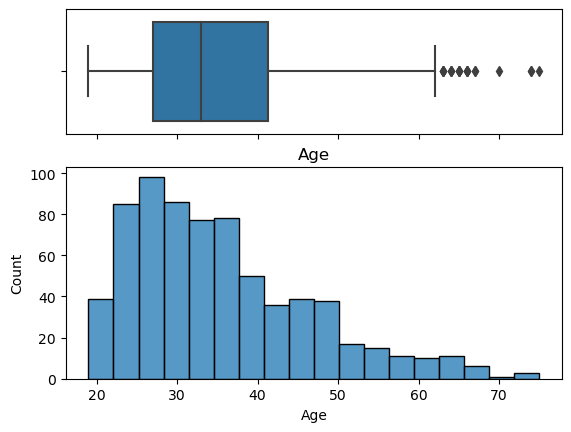

In [117]:
plot_boxplot_and_hist(X_train_, "Age") # before trimming

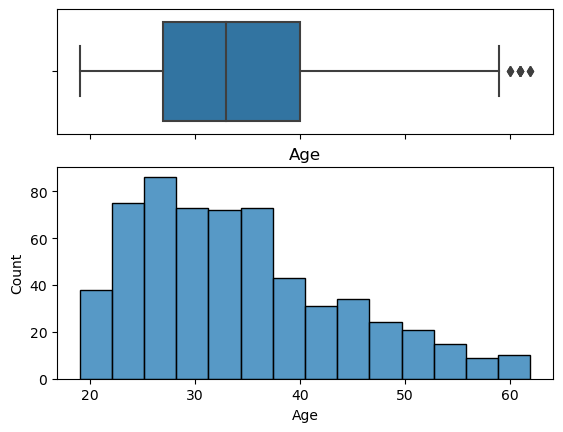

In [118]:
plot_boxplot_and_hist(X_train__, "Age") # after trimming

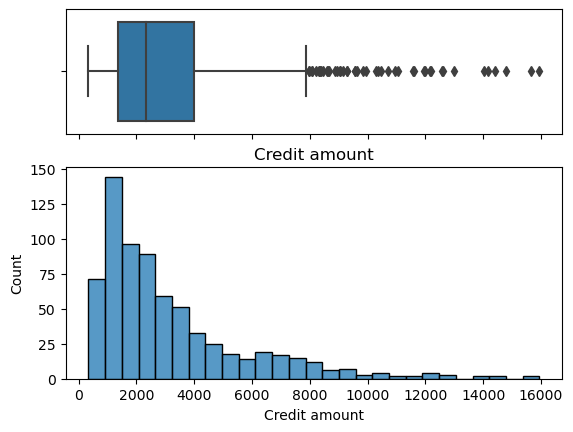

In [119]:
plot_boxplot_and_hist(X_train_, "Credit amount") # before trimming

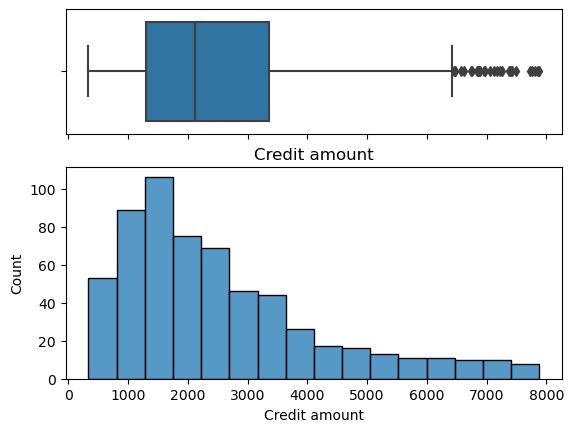

In [120]:
plot_boxplot_and_hist(X_train__, "Credit amount") # after trimming

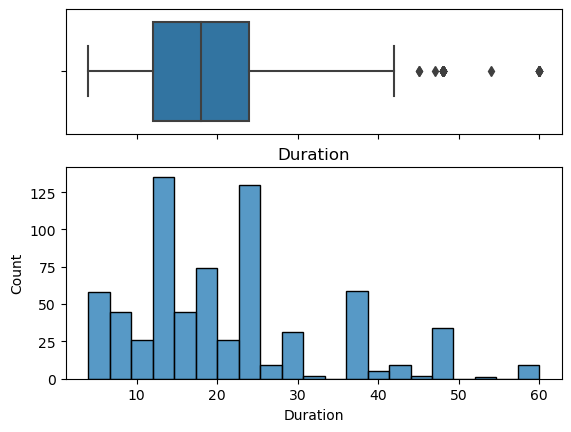

In [121]:
plot_boxplot_and_hist(X_train_, "Duration") # before trimming

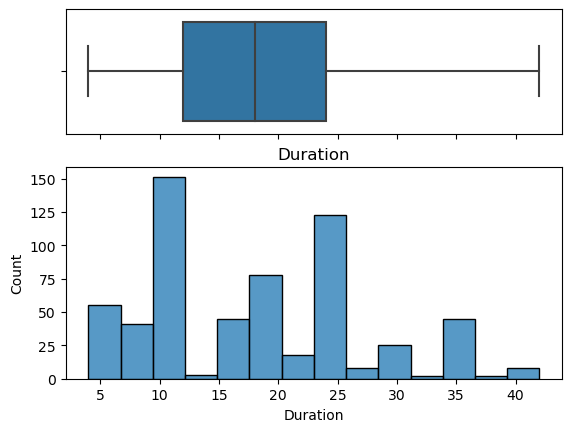

In [122]:
plot_boxplot_and_hist(X_train__, "Duration") # after trimming

### Export dataset

We will export our filtered dataset to use in part 2:

In [123]:
X_train__.to_csv('E:/0 Projects/Project 8/dataset/ds_train.csv', index=False)
X_test__.to_csv('E:/0 Projects/Project 8/dataset/ds_test.csv', index=False)